In [7]:
from qiskit import IBMQ, BasicAer ,Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
import math as math
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Union, List
from copy import deepcopy
from qiskit.circuit import ParameterVector, Parameter
from collections import defaultdict
from scipy.optimize import minimize
from qiskit.quantum_info.states import partial_trace
from qiskit import QuantumCircuit, QuantumRegister

### Search circuit: As discussed in page 10 https://arxiv.org/pdf/2105.02859.pdf

We are showing here search over a two qubit state $\lvert q_1 q_2 \rangle$ where we assume the marked state be $\lvert 11 \rangle$. 
We start the procedure with $\lvert 00 \rangle$ state.

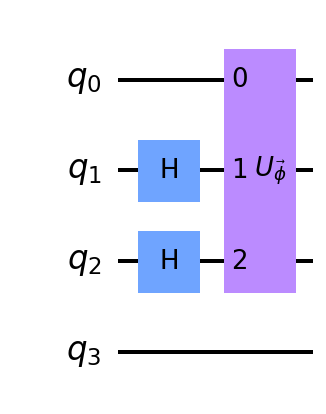

In [16]:
def named_circ(name, nqubit, control=True):
    qc1 = QuantumCircuit(nqubit, name=name)
    if control:
        named_circ = qc1.to_gate().control(1)
    else:
        named_circ = qc1.to_gate()
    
    return named_circ


qc2 = QuantumCircuit(4)
    
qc2.append(named_circ(r'$U_{\vec{\phi}}$', nqubit=3, control=False), [0,1,2])
qc2.draw('mpl', scale=2.0)

The $$
U_{\vec{\phi}}=\tilde{\Pi}_{\phi_{1}} U\left[\prod_{k=1}^{(d-1) / 2} \Pi_{\phi_{2 k}} U^{\dagger} \tilde{\Pi}_{\phi_{2 k+1}} U\right]
$$

Based on the discussion, in these settings $U$ can be set to $H^{\otimes 2}$.

Now $\Pi_{\phi} = e^{i\phi (2\Pi -I)}$, where $\Pi = \lvert 00 \rangle \langle 00 \rvert$ is the projector on the initial state. 
The circuit for $\Pi_{\phi}$ is shown below. 

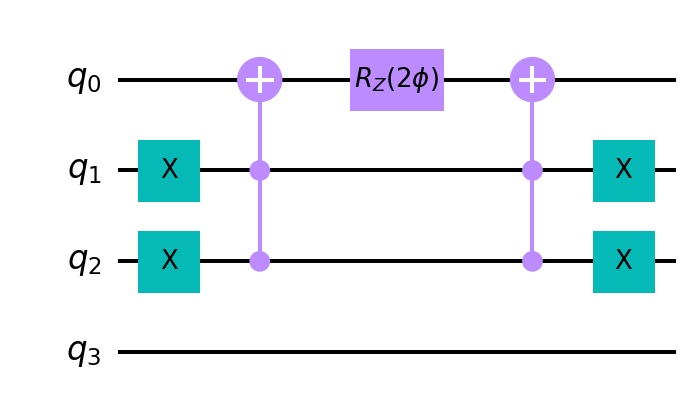

In [26]:
qc3 = QuantumCircuit(4)

qc3.x(1)
qc3.x(2)
qc3.mcx([1,2], target_qubit=0)
qc3.append(named_circ(r'$R_Z(2\phi)$', nqubit=1, control=False), [0])
qc3.mcx([1,2], target_qubit=0)
qc3.x(1)
qc3.x(2)
 
qc3.draw('mpl', scale=2.0)

We know describe the oracle $Q$ that is given to us to mark the marked state.
$Q \lvert j \rangle = (-1)^p \lvert j \rangle$, where $p = 1$ when $\lvert j \rangle$ is the marked state, else $p=0$. As we choose
$\lvert 11 \rangle$ be the marked state, the oracle circuit can be a controlled-Z gate.

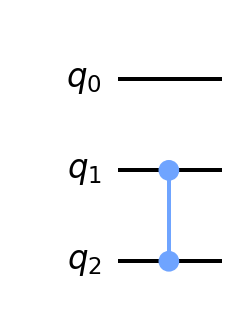

In [57]:
qc4 = QuantumCircuit(3)

qc4.cz(1, 2)

qc4.draw('mpl', scale=2.0)

Now to implement $\tilde{\Pi}_{\phi} = C_{\tilde{\Pi}}NOT (RZ(2\phi) \otimes I) C_{\tilde{\Pi}}NOT$. Note, $\tilde{\Pi} = \lvert m \rangle 
\langle m \rvert$, where $m$ is the marked state. Also, we know that
$$ C_{\tilde{\Pi}}NOT = I \otimes (I - \tilde{\Pi}) + X \otimes \tilde{\Pi}.$$ 
In order to implement $C_{\tilde{\Pi}}NOT$, a circuit shown below can be used

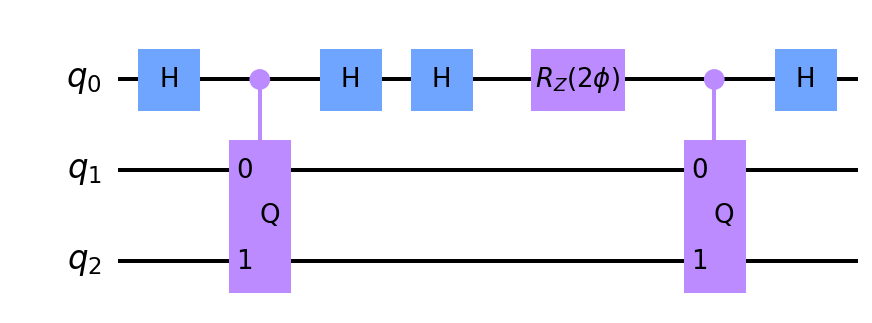

In [90]:
qc5 = QuantumCircuit(3)
qc_temp = QuantumCircuit(2, name=r'Q')
qc_temp.cz(0, 1)
q_gate = qc_temp.to_gate().control(1)

qc5.h(0)
qc5.append(q_gate, [0, 1, 2])
qc5.h(0)

qc5.h(0)
qc5.append(named_circ(r'$R_Z(2\phi)$', nqubit=1, control=False), [0])
qc5.append(q_gate, [0, 1, 2])
qc5.h(0)

qc5.draw('mpl', scale=2.0)

Now we will bring all the pieces together in a single circuit

#### Grover search using QSVT

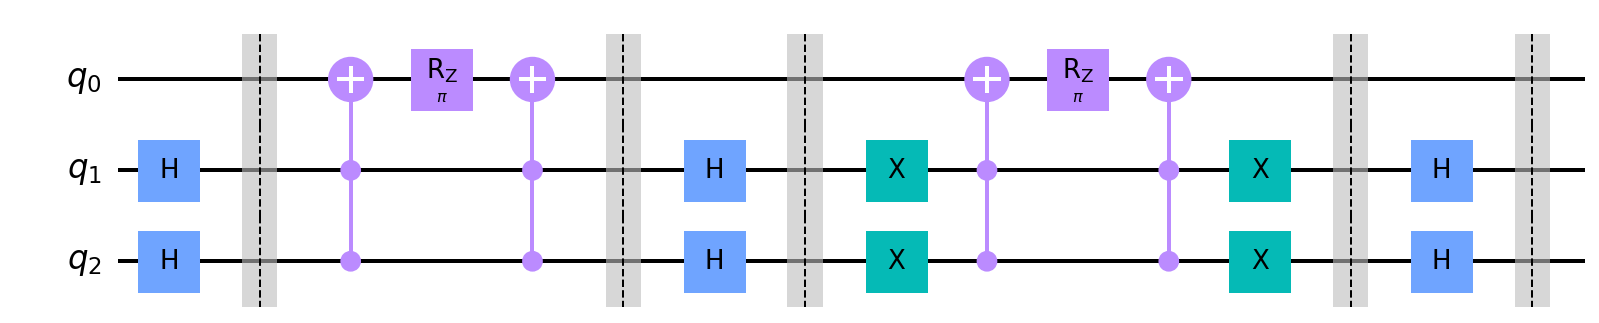

In [477]:
qc = QuantumCircuit(3)

#first apply U
qc.h(1)
qc.h(2)
qc.barrier()

#\Pi_tilde
qc.mcx([1,2], target_qubit=0)
qc.rz(np.pi, 0)
qc.mcx([1,2], target_qubit=0)
#qc.measure_all()
qc.barrier()

#now U^{dagger}
qc.h(1)
qc.h(2)
qc.barrier()

#Pi_{\phi}
qc.x(1)
qc.x(2)
qc.mcx([1,2], target_qubit=0)
qc.rz(np.pi, 0)
qc.mcx([1,2], target_qubit=0)
qc.x(1)
qc.x(2)
#qc.measure_all()
qc.barrier()

#another U
qc.h(1)
qc.h(2)
qc.barrier()

#qc.decompose()
qc.draw('mpl', scale=2.0)

#### Here we implement a flexible oracle Q

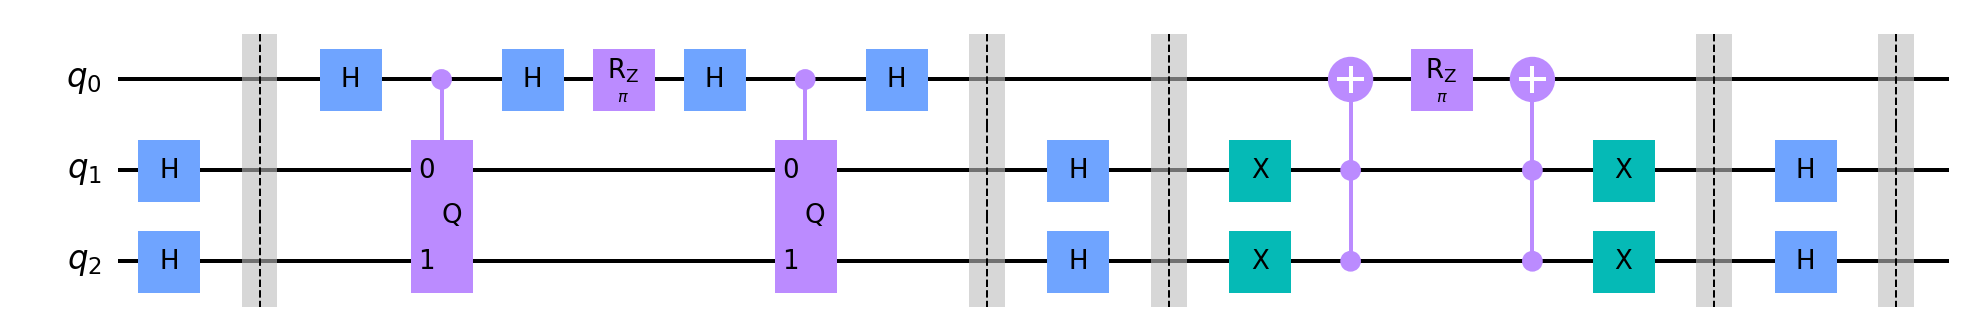

In [155]:
qc = QuantumCircuit(3)

#first apply U
qc.h(1)
qc.h(2)
qc.barrier()

#then apply \tilde{Pi}_{phi}
qc_temp = QuantumCircuit(2, name=r'Q')
qc_temp.cz(0, 1)
q_gate = qc_temp.to_gate().control(1)

qc.h(0)
qc.append(q_gate, [0, 1, 2])
qc.h(0)

qc.rz(np.pi, 0)
qc.h(0)
qc.append(q_gate, [0, 1, 2])
qc.h(0)
qc.barrier()

#now U^{dagger}
qc.h(1)
qc.h(2)
qc.barrier()

#Pi_{\phi}
qc.x(1)
qc.x(2)
qc.mcx([1,2], target_qubit=0)
qc.rz(np.pi, 0)
qc.mcx([1,2], target_qubit=0)
qc.x(1)
qc.x(2)
#qc.measure_all()
qc.barrier()

#another U
qc.h(1)
qc.h(2)
qc.barrier()

#qc.decompose()
qc.draw('mpl', scale=2.0)

In [478]:
simulator = Aer.get_backend('statevector_simulator')
result = execute(qc, backend = simulator).result()
answer_X = result.get_statevector(qc)

result.get_counts()
answer_X

array([2.12520397e-16-3.05720888e-32j, 0.00000000e+00+0.00000000e+00j,
       1.99673462e-16+1.22464680e-16j, 0.00000000e+00+0.00000000e+00j,
       2.12520397e-16+1.22464680e-16j, 0.00000000e+00+0.00000000e+00j,
       1.00000000e+00-1.83697020e-16j, 0.00000000e+00+0.00000000e+00j])

#### Using phase angles from the paper

In [247]:
phi = [0.01558127, -0.01805798, 0.05705643, -0.01661832,
0.16163773, 0.09379074, -2.62342885, 0.49168481, 
0.92403822, -0.09696846, -0.09696846, 0.92403822,
0.49168481, -2.62342885, 0.09379074, 0.16163773, 
-0.01661832, 0.05705643, -0.01805798, 1.5863776]

for i in range(1, len(phi)-1):
    phi[i] = (phi[i] + np.pi/2.0)
    
phi[0] = np.pi/4
phi[-1] = phi[-1] + np.pi/4 

In [248]:

def run_qsvt_search(theta):
    
    qc = QuantumCircuit(3)
    d = len(phi)

    qc.ry(theta, 1)
    qc.ry(theta, 2)
    #qc.barrier()

    for k in range(d//2, 0, -1):
        #apply \tilde{Pi}_{phi}
        qc.mcx([1,2], target_qubit=0)
        qc.rz(2 * phi[2*k-1], 0)
        qc.mcx([1,2], target_qubit=0)
        qc.barrier()

        #apply U^dag
        qc.ry(-theta, 1)
        qc.ry(-theta, 2)
        qc.barrier()
        
        #Pi_{\phi}
        qc.x(1)
        qc.x(2)
        qc.mcx([1,2], target_qubit=0)
        qc.rz(2 * phi[2*k-2], 0)
        qc.mcx([1,2], target_qubit=0)
        qc.x(1)
        qc.x(2)
        #qc.measure_all()
        qc.barrier()
    
        #apply U
        qc.ry(theta, 1)
        qc.ry(theta, 2)
        qc.barrier()

    #qc.decompose()
    #print(qc.draw('mpl', scale=2.0))
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(qc, backend = simulator).result()
    answer_X = result.get_statevector(qc)
    
    return qc, result, answer_X
    
    
def prepare_initial_state(theta):
    qc = QuantumCircuit(3)

    qc.ry(theta, 1)
    qc.ry(theta, 2)
    
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(qc, backend = simulator).result()
    answer_X = result.get_statevector(qc)
    
    return qc, result, answer_X

def prepare_target_state():
    
    qc = QuantumCircuit(3)

    qc.x(1)
    qc.x(2)
    
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(qc, backend = simulator).result()
    answer_X = result.get_statevector(qc)
    
    return qc, result, answer_X

In [152]:
qc, result, X = prepare_initial_state(np.pi/2.0)
result.get_counts()
X

array([0.5+0.j, 0. +0.j, 0.5+0.j, 0. +0.j, 0.5+0.j, 0. +0.j, 0.5+0.j,
       0. +0.j])

{'000': 0.010963048415423, '010': 0.010963048415423, '100': 0.010963048415423, '110': 0.967110854753729}


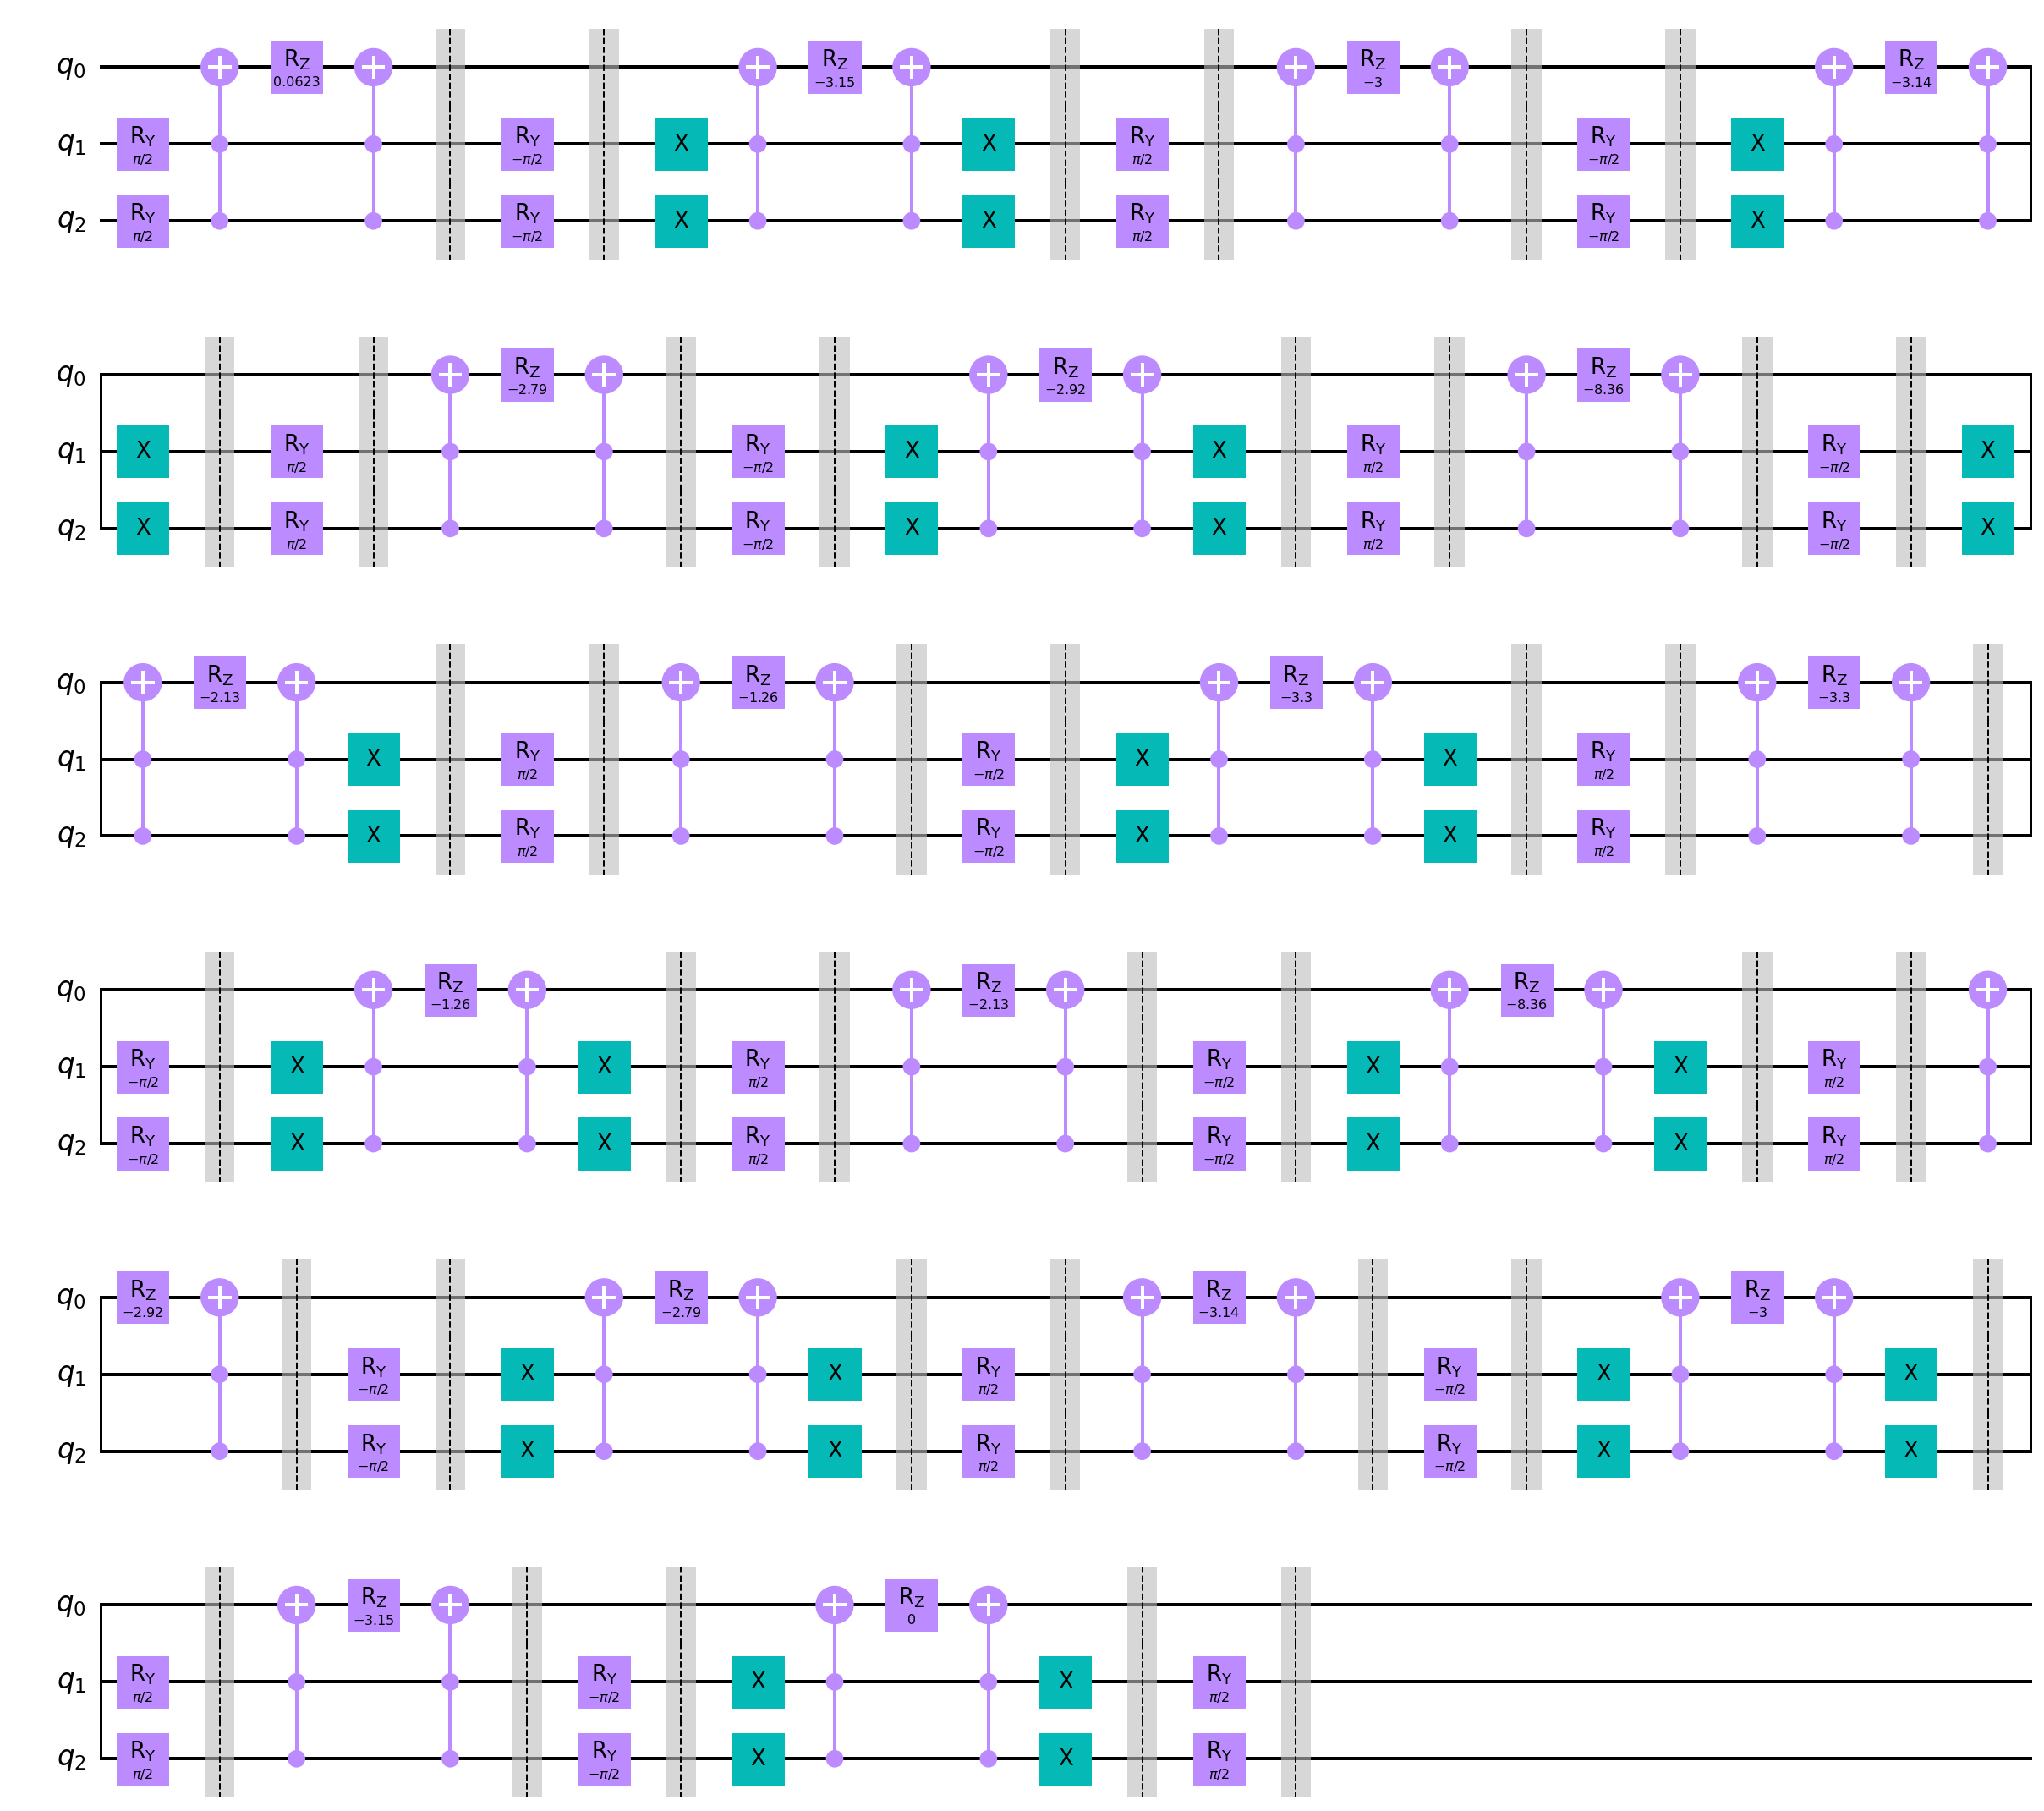

In [240]:
qc, result, X = run_qsvt_search(np.pi/2.0)

print(result.get_counts())
qc.draw('mpl', scale=2.0)

In [249]:
import collections

xfx = {}
for theta in np.arange(0, 2*np.pi, np.pi/64):
    if '110' in run_qsvt_search(theta)[1].get_counts().keys():
        fx = np.sqrt(run_qsvt_search(theta)[1].get_counts()['110'])
        x = np.sqrt(prepare_initial_state(theta)[1].get_counts()['110']) 
    else:
        fx = 0.0
        x = 0.0
                    
    xfx[x] = fx

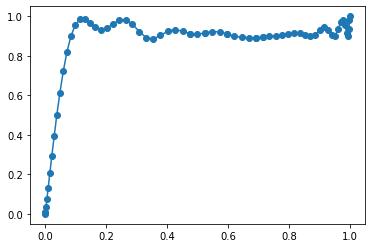

In [250]:
ordered_xfx = collections.OrderedDict(sorted(xfx.items()))
plt.plot(ordered_xfx.keys(), ordered_xfx.values(), '-o')

/opt/anaconda3/envs/qiskit/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


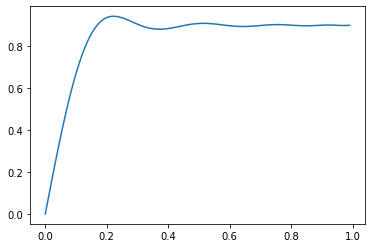

In [8]:
phi = [0.01558127, -0.01805798, 0.05705643, -0.01661832,
0.16163773, 0.09379074, -2.62342885, 0.49168481, 
0.92403822, -0.09696846, -0.09696846, 0.92403822,
0.49168481, -2.62342885, 0.09379074, 0.16163773, 
-0.01661832, 0.05705643, -0.01805798, 1.5863776]


def W(x): 

    return np.matrix([[x, 1j * np.sqrt(1 - x**2)],
                   [1j * np.sqrt(1 - x**2), x]])

def rZ(theta):
    
    return np.matrix([[np.exp(-1j * theta), 0],
                   [0, np.exp(1j * theta)]])

def end_m(x):
    
    ans = rZ(phi[0]) 
    for i in range(1, len(phi)):
        ans *= W(x) * rZ(phi[i])

    return ans

px = []
for i in np.arange(0,1,0.01):
    px.append(end_m(i)[0,0])
    
plt.plot(np.arange(0,1,0.01), px)

/opt/anaconda3/envs/qiskit/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


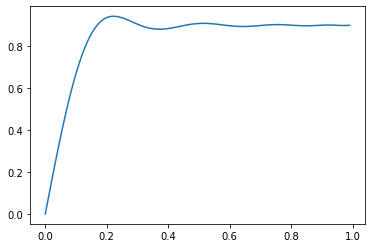

In [12]:
phi = [0.01558127, -0.01805798, 0.05705643, -0.01661832,
0.16163773, 0.09379074, -2.62342885, 0.49168481, 
0.92403822, -0.09696846, -0.09696846, 0.92403822,
0.49168481, -2.62342885, 0.09379074, 0.16163773, 
-0.01661832, 0.05705643, -0.01805798, 1.5863776]

#we transfrom from W to O convention
#for i in range(1, len(phi)-1):
#    phi[i] = (phi[i] + np.pi/2.0)
    
phi[0] = phi[0] - np.pi/4
phi[-1] = phi[-1] + np.pi/4 

kappa = 3.0

def W(x): 

    return np.matrix([[x, -np.sqrt(1 - x**2)],
                   [np.sqrt(1 - x**2), x]])

def rZ(theta):
    
    return np.matrix([[np.exp(-1j * theta), 0],
                   [0, np.exp(1j * theta)]])

def end_m(x):
    
    ans = rZ(phi[0]) 
    for i in range(1, len(phi)):
        ans *= W(x) * rZ(phi[i])

    return ans

px = []
for i in np.arange(0,1,0.01):
    px.append(end_m(i)[0,0])
    
plt.plot(np.arange(0,1,0.01), px)

In [421]:
px

[(-0.8996747162204914+0.43656088349000965j),
 (-0.899802836282547-0.17781837783379678j),
 (-0.8991687303882523-0.4190254760301503j),
 (-0.8988660386393185-0.4064277085158329j),
 (-0.8991094047382773-0.24881108273382238j),
 (-0.8997165611701158-0.03456886661802572j),
 (-0.9003935337625688+0.1718068234937967j),
 (-0.9008857464189034+0.32918652973039675j),
 (-0.9010417280611029+0.41688280133439126j),
 (-0.9008234097345678+0.43054327786056784j),
 (-0.9002870694070648+0.3776863680503656j),
 (-0.8995513373800935+0.2734253613170058j),
 (-0.8987628918418691+0.1367125349947344j),
 (-0.8980661917468967-0.012723705042990668j),
 (-0.8975805091189276-0.15668941103498293j),
 (-0.8973853804533137-0.2801025249029412j),
 (-0.8975141853064712-0.37190696075553664j),
 (-0.8979547045613957-0.4254226215597332j),
 (-0.8986550682604424-0.43824421905491795j),
 (-0.8995333576011548-0.41180380058864213j),
 (-0.9004891852431659-0.3507058709554296j),
 (-0.9014157696924002-0.2619327179715087j),
 (-0.902211286962296